# Exercise 9: Decorrelation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import scipy.stats as stats

import pickle

Below we create a simple dataset. The signal consists of 5 uncorrelated Gaussian distributions, the background is flat

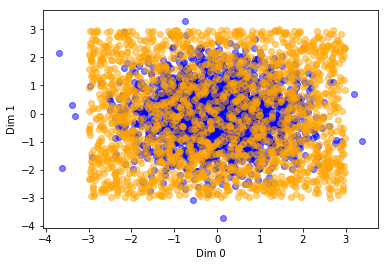

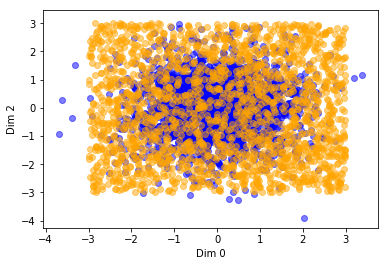

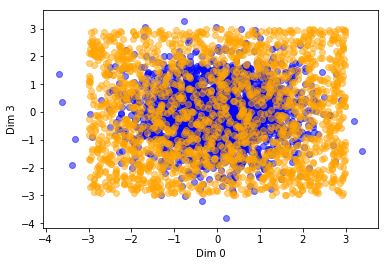

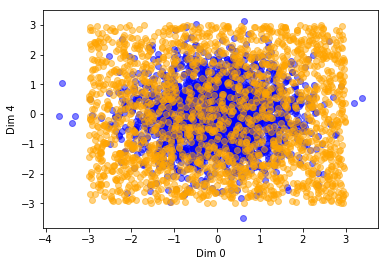

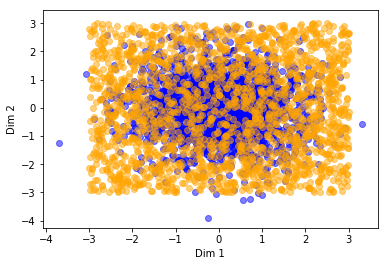

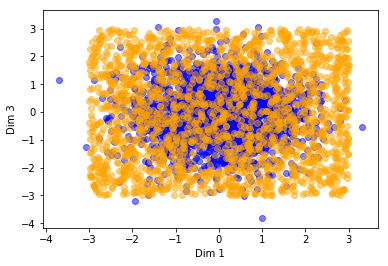

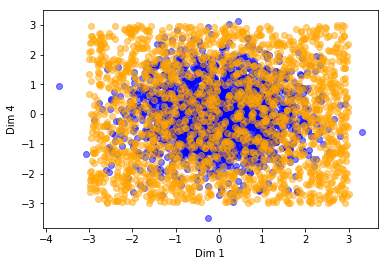

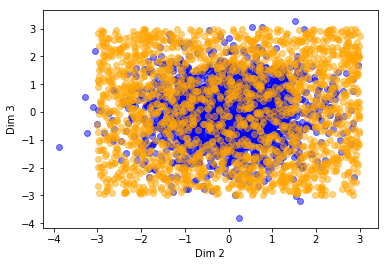

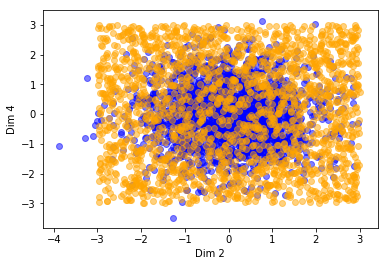

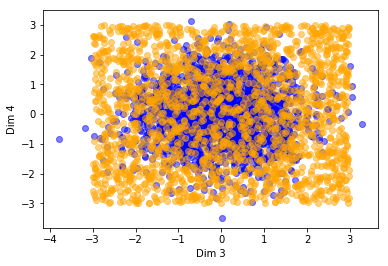

In [2]:
sig = np.random.normal(size=(2000,5))
bg = np.random.uniform(low=-3, high=3, size=(2000,5))

data = np.concatenate([sig,bg]) # combine signal and background
labels = np.concatenate([np.ones(2000), np.zeros(2000)]) # and also create labels - one for signal and zero for background

# shuffle the examples and indices
idx = np.arange(data.shape[0])
np.random.shuffle(idx)
data = data[idx]
labels = labels[idx]

# select subsets as training and testing data
X_train = data[:1500]
y_train = labels[:1500]

X_test = data[1500:]
y_test = labels[1500:]

# and visualize the distributions
def plot2d(xdim, ydim):
    plt.clf()
    plt.scatter(sig[:,xdim],sig[:,ydim],color='blue',alpha=0.5)
    plt.scatter(bg[:,ydim],bg[:,xdim],color='orange',alpha=0.5)
    plt.xlabel("Dim {0}".format(xdim))
    plt.ylabel("Dim {0}".format(ydim))
    plt.show()
    
plot2d(0,1)
plot2d(0,2)
plot2d(0,3)
plot2d(0,4)
plot2d(1,2)
plot2d(1,3)
plot2d(1,4)
plot2d(2,3)
plot2d(2,4)
plot2d(3,4)


# Homework 1


  * Implement a fully connected network using all 5 input variables. What is the best accuracy it obtains and how strong does it affect the distribution of variable 0 (the code to draw the distribution and calculate the JS divergence are provided above)

In [3]:
# SOLUTION
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        # 5 Inputs - 20 Hidden Nodes - 1 Output
        self.fc1 = nn.Linear(5, 20)
        self.fc2 = nn.Linear(20, 1)
        
    def forward(self, x):
        
        x = F.relu(self.fc1.forward(x))
        x = self.fc2.forward(x)

        x = F.sigmoid(x)

        return x

    
# Which device to use for NN calculations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

# Create network object
model = NeuralNet().to(device)

# Adam optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# how many epochs to train for
n_epochs = 20 

# how many examples / batch
batch_size = 5

# Keep track of the accuracies
train_accs = []
test_accs = []

/Users/gregor/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/gregor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])) is deprecated. Please ensure they have the same size.


Epoch: 0 Train Accuracy: 0.48933333333333334 Test Accuracy: 0.4816
Epoch: 1 Train Accuracy: 0.634 Test Accuracy: 0.6256
Epoch: 2 Train Accuracy: 0.7566666666666667 Test Accuracy: 0.7456
Epoch: 3 Train Accuracy: 0.7993333333333333 Test Accuracy: 0.7944
Epoch: 4 Train Accuracy: 0.8313333333333334 Test Accuracy: 0.8132
Epoch: 5 Train Accuracy: 0.8413333333333334 Test Accuracy: 0.8272
Epoch: 6 Train Accuracy: 0.8566666666666667 Test Accuracy: 0.8356
Epoch: 7 Train Accuracy: 0.8626666666666667 Test Accuracy: 0.8392
Epoch: 8 Train Accuracy: 0.8653333333333333 Test Accuracy: 0.8424
Epoch: 9 Train Accuracy: 0.8673333333333333 Test Accuracy: 0.8428
Epoch: 10 Train Accuracy: 0.8666666666666667 Test Accuracy: 0.844
Epoch: 11 Train Accuracy: 0.868 Test Accuracy: 0.8464
Epoch: 12 Train Accuracy: 0.8693333333333333 Test Accuracy: 0.8476
Epoch: 13 Train Accuracy: 0.8713333333333333 Test Accuracy: 0.8468
Epoch: 14 Train Accuracy: 0.8726666666666667 Test Accuracy: 0.8448
Epoch: 15 Train Accuracy: 0.874

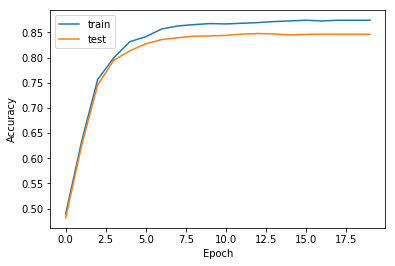

Best test accuracy: 0.8476


In [4]:
# Train the model 
train_examples = X_train.shape[0]
n_batches = int(train_examples/batch_size)

# Loop over the epochs
for ep in range(n_epochs):
    
    # Each epoch is a complete loop over the training data
    for i in range(n_batches):
        
        # Reset gradient
        optimizer.zero_grad()
        
        i_start = i*batch_size
        i_stop  = (i+1)*batch_size
        
        # Convert x and y to proper objects for PyTorch
        x = torch.tensor(X_train[i_start:i_stop],dtype=torch.float)
        y = torch.tensor(y_train[i_start:i_stop],dtype=torch.long)

        
        # Apply the network 
        net_out = model(x)
        
        loss = F.binary_cross_entropy(net_out,y.float())
        
    
        # Calculate the gradients
        loss.backward()

        # Update the weights
        optimizer.step()
        

    # end of loop over batches
        
    # Calculate predictions on training and testing data
    y_pred_train = model(torch.tensor(X_train,dtype=torch.float)).detach().numpy()[:,0]
    y_pred_test  = model(torch.tensor(X_test,dtype=torch.float)).detach().numpy()[:,0]
    
    # Calculate accuracy on training and testing data
    train_acc = sum(y_train.astype(bool) == (y_pred_train>0.5)) / y_train.shape[0]
    test_acc = sum(y_test.astype(bool) == (y_pred_test>0.5)) / y_test.shape[0]
    
    # print some information
    print("Epoch:",ep, "Train Accuracy:", train_acc,  "Test Accuracy:", test_acc)
    
    # and store the accuracy for later use
    train_accs.append(train_acc)
    test_accs.append(test_acc)
# end of loop over epochs
    
# Prepare and show accuracy over time
plt.axis('on')
plt.plot(train_accs,label="train")
plt.plot(test_accs,label="test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

print("Best test accuracy:",max(test_accs))

0.13390701513131428

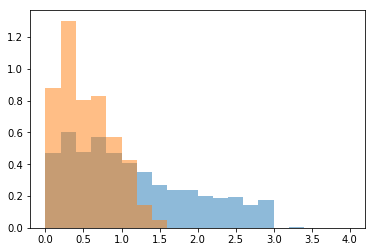

In [5]:
# Helper function to calculate the jensen shannon divergence
def calc_js(P,Q,nbins=25):

    # find lowest and highest value
    low = min(min(P), min(Q))
    high = max(max(P), max(Q))

    # turn distributions into histograms
    P_h,_ = np.histogram(P, bins=nbins, range=(low,high),density=True)
    Q_h,_ = np.histogram(Q, bins=nbins, range=(low,high),density=True)

    # calculate average histgrogram
    M_h = 0.5 * (P_h + Q_h)
    
    # and add KL divergences
    JS = 0.5 * stats.entropy(P_h,M_h) + 0.5 * stats.entropy(Q_h,M_h)
    
    return JS

# Evaluate DNN on testing data
x = torch.tensor(X_test,dtype=torch.float)
y_pred = model(x).detach().numpy()[:,0]

# Find the threshold corresponding to 70% efficiency for true signal events
threshold = np.percentile(y_pred[y_test==1],70)

# select events that pass (ie lie above that threshold)
passed_selection = (y_pred > threshold)

# Plot the distribution of all events before and after the selection
_ = plt.hist(X_test[:,0],bins=20,density=True,range=(0,4),alpha=0.5)
_ = plt.hist(X_test[passed_selection,0],bins=20,density=True,range=(0,4),alpha=0.5)

# and calculate the jensen shannon divergence
calc_js(X_test[:,0],X_test[passed_selection,0])

# Homework 2

  
  * By how much does the accuracy and shaping change if you do NOT use the first input variable. You will need to change the network and all instances where the data is passed to the model. You can use `X[:,1:]` to select the sub-tensor without the first column


In [6]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        # 4 Inputs - 20 Hidden Nodes - 1 Output
        self.fc1 = nn.Linear(4, 20)
        self.fc2 = nn.Linear(20, 1)
        
    def forward(self, x):
        
        x = F.relu(self.fc1.forward(x))
        x = self.fc2.forward(x)

        x = F.sigmoid(x)

        return x
    
        
# Which device to use for NN calculations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

# Create network object
model = NeuralNet().to(device)

# Adam optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# how many epochs to train for
n_epochs = 20 

# how many examples / batch
batch_size = 5

# Keep track of the accuracies
train_accs = []
test_accs = []


/Users/gregor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])) is deprecated. Please ensure they have the same size.


Epoch: 0 Train Accuracy: 0.6973333333333334 Test Accuracy: 0.6896
Epoch: 1 Train Accuracy: 0.7513333333333333 Test Accuracy: 0.7476
Epoch: 2 Train Accuracy: 0.8 Test Accuracy: 0.79
Epoch: 3 Train Accuracy: 0.8233333333333334 Test Accuracy: 0.8084
Epoch: 4 Train Accuracy: 0.8326666666666667 Test Accuracy: 0.8224
Epoch: 5 Train Accuracy: 0.8346666666666667 Test Accuracy: 0.8256
Epoch: 6 Train Accuracy: 0.8366666666666667 Test Accuracy: 0.8288
Epoch: 7 Train Accuracy: 0.8413333333333334 Test Accuracy: 0.8296
Epoch: 8 Train Accuracy: 0.844 Test Accuracy: 0.83
Epoch: 9 Train Accuracy: 0.8466666666666667 Test Accuracy: 0.8316
Epoch: 10 Train Accuracy: 0.848 Test Accuracy: 0.8324
Epoch: 11 Train Accuracy: 0.8466666666666667 Test Accuracy: 0.8336
Epoch: 12 Train Accuracy: 0.8466666666666667 Test Accuracy: 0.834
Epoch: 13 Train Accuracy: 0.846 Test Accuracy: 0.834
Epoch: 14 Train Accuracy: 0.846 Test Accuracy: 0.8344
Epoch: 15 Train Accuracy: 0.8453333333333334 Test Accuracy: 0.8316
Epoch: 16 T

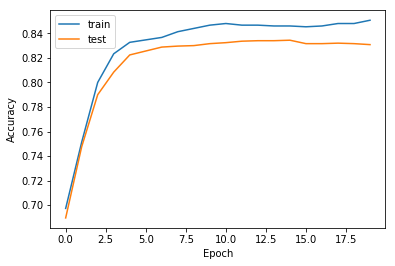

Best test accuracy: 0.8344


In [7]:
# Train the model 
# (lines changed with respect to above version marked with !!!)

train_examples = X_train.shape[0]
n_batches = int(train_examples/batch_size)

# Loop over the epochs
for ep in range(n_epochs):
    
    # Each epoch is a complete loop over the training data
    for i in range(n_batches):
        
        # Reset gradient
        optimizer.zero_grad()
        
        i_start = i*batch_size
        i_stop  = (i+1)*batch_size
        
        # Convert x and y to proper objects for PyTorch
        x = torch.tensor(X_train[i_start:i_stop],dtype=torch.float) # !!!
        y = torch.tensor(y_train[i_start:i_stop],dtype=torch.long)

                
        # Apply the network 
        net_out = model(x[:,1:])
        
        loss = F.binary_cross_entropy(net_out,y.float())
        
    
        # Calculate the gradients
        loss.backward()

        # Update the weights
        optimizer.step()
        

    # end of loop over batches
        
    # Calculate predictions on training and testing data
    y_pred_train = model(torch.tensor(X_train[:,1:],dtype=torch.float)).detach().numpy()[:,0] #!!!
    y_pred_test  = model(torch.tensor(X_test[:,1:],dtype=torch.float)).detach().numpy()[:,0] #!!!
    
    # Calculate accuracy on training and testing data
    train_acc = sum(y_train.astype(bool) == (y_pred_train>0.5)) / y_train.shape[0]
    test_acc = sum(y_test.astype(bool) == (y_pred_test>0.5)) / y_test.shape[0]
    
    # print some information
    print("Epoch:",ep, "Train Accuracy:", train_acc,  "Test Accuracy:", test_acc)
    
    # and store the accuracy for later use
    train_accs.append(train_acc)
    test_accs.append(test_acc)
# end of loop over epochs
    
# Prepare and show accuracy over time
plt.axis('on')
plt.plot(train_accs,label="train")
plt.plot(test_accs,label="test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

print("Best test accuracy:",max(test_accs))

0.04249299609782578

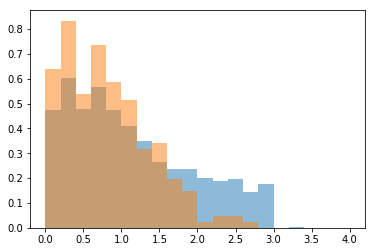

In [8]:
# Evaluate DNN on testing data
x = torch.tensor(X_test,dtype=torch.float)
y_pred = model(x[:,1:]).detach().numpy()[:,0] #!!!

# Find the threshold corresponding to 70% efficiency for true signal events
threshold = np.percentile(y_pred[y_test==1],70)

# select events that pass (ie lie above that threshold)
passed_selection = (y_pred > threshold)

# Plot the distribution of all events before and after the selection
_ = plt.hist(X_test[:,0],bins=20,density=True,range=(0,4),alpha=0.5)
_ = plt.hist(X_test[passed_selection,0],bins=20,density=True,range=(0,4),alpha=0.5)

# and calculate the jensen shannon divergence
calc_js(X_test[:,0],X_test[passed_selection,0])

# Homework 3

  * Calculate weights that flatten the input distribution of the first input variable but use it as input to the network. Helpful numpy functions are `np.histogram` and `np.digitize`. The `binary_cross_entropy` loss functions has an argument `weight` that accepts a tensor with the same shape as `y` that contains the weight. Calculate the weight for each example and use in training. How much does this change accuracy and shaping?

In [9]:
# Calculate weights

# histogram contains a list of bins contents, edges the boundaries
# We build a histogram of variable 0
histogram, edges = np.histogram(data[:,0])

# remove lover/uppermost edge
edges = edges[1:]
edges = edges[:9]

# weights are 1/bin contents
weights = 1./ histogram
weights



array([0.16666667, 0.00390625, 0.00280899, 0.00184843, 0.0014556 ,
       0.0012987 , 0.00161551, 0.0025974 , 0.0037594 , 0.00877193])

In [10]:
# SOLUTION
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        # 5 Inputs - 20 Hidden Nodes - 1 Output
        self.fc1 = nn.Linear(5, 20)
        self.fc2 = nn.Linear(20, 1)
        
    def forward(self, x):
        
        x = F.relu(self.fc1.forward(x))
        x = self.fc2.forward(x)

        x = F.sigmoid(x)

        return x

    
# Which device to use for NN calculations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

# Create network object
model = NeuralNet().to(device)

# Adam optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# how many epochs to train for
n_epochs = 20 

# how many examples / batch
batch_size = 5

# Keep track of the accuracies
train_accs = []
test_accs = []

/Users/gregor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])) is deprecated. Please ensure they have the same size.


Epoch: 0 Train Accuracy: 0.5053333333333333 Test Accuracy: 0.4836
Epoch: 1 Train Accuracy: 0.5246666666666666 Test Accuracy: 0.5048
Epoch: 2 Train Accuracy: 0.5406666666666666 Test Accuracy: 0.5272
Epoch: 3 Train Accuracy: 0.584 Test Accuracy: 0.5656
Epoch: 4 Train Accuracy: 0.6206666666666667 Test Accuracy: 0.6052
Epoch: 5 Train Accuracy: 0.6693333333333333 Test Accuracy: 0.6464
Epoch: 6 Train Accuracy: 0.704 Test Accuracy: 0.68
Epoch: 7 Train Accuracy: 0.73 Test Accuracy: 0.7092
Epoch: 8 Train Accuracy: 0.7526666666666667 Test Accuracy: 0.732
Epoch: 9 Train Accuracy: 0.7666666666666667 Test Accuracy: 0.7492
Epoch: 10 Train Accuracy: 0.7893333333333333 Test Accuracy: 0.7576
Epoch: 11 Train Accuracy: 0.794 Test Accuracy: 0.766
Epoch: 12 Train Accuracy: 0.7993333333333333 Test Accuracy: 0.7744
Epoch: 13 Train Accuracy: 0.8066666666666666 Test Accuracy: 0.7812
Epoch: 14 Train Accuracy: 0.8113333333333334 Test Accuracy: 0.7852
Epoch: 15 Train Accuracy: 0.814 Test Accuracy: 0.7908
Epoch: 1

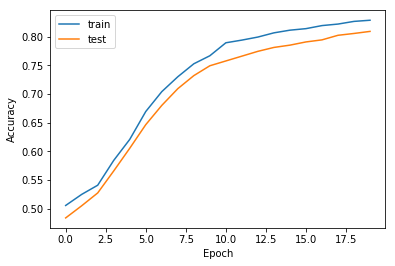

Best test accuracy: 0.8092


In [11]:
train_examples = X_train.shape[0]
n_batches = int(train_examples/batch_size)

# Loop over the epochs
for ep in range(n_epochs):

    # Calculate the weights
    # digitize tells us in which bin (defined by edges) an entry is (reverse histogram function)
    weights_train = weights[np.digitize(X_train[:,0],edges)]
    weights_test  = weights[np.digitize(X_test[:,0],edges)]
    
    # Each epoch is a complete loop over the training data
    for i in range(n_batches):
        
        # Reset gradient
        optimizer.zero_grad()
        
        i_start = i*batch_size
        i_stop  = (i+1)*batch_size
        
        # Convert x and y to proper objects for PyTorch
        x = torch.tensor(X_train[i_start:i_stop],dtype=torch.float)
        y = torch.tensor(y_train[i_start:i_stop],dtype=torch.long)

        # select the right weights and convert to torch tensor
        w = torch.tensor(weights_train[i_start:i_stop],dtype=torch.float)
        
        
        # Apply the network 
        net_out = model(x)
        
        # train and apply weights
        loss = F.binary_cross_entropy(net_out,y.float(),weight=w)
            
        # Calculate the gradients
        loss.backward()

        # Update the weights
        optimizer.step()
        

    # end of loop over batches
        
   # Calculate predictions on training and testing data
    y_pred_train = model(torch.tensor(X_train,dtype=torch.float)).detach().numpy()[:,0]
    y_pred_test  = model(torch.tensor(X_test,dtype=torch.float)).detach().numpy()[:,0]
    
    # Calculate accuracy on training and testing data
    train_acc = sum(y_train.astype(bool) == (y_pred_train>0.5)) / y_train.shape[0]
    test_acc = sum(y_test.astype(bool) == (y_pred_test>0.5)) / y_test.shape[0]
        
    # print some information
    print("Epoch:",ep, "Train Accuracy:", train_acc,  "Test Accuracy:", test_acc)
    
    # and store the accuracy for later use
    train_accs.append(train_acc)
    test_accs.append(test_acc)
# end of loop over epochs
    
# Prepare and show accuracy over time
plt.axis('on')
plt.plot(train_accs,label="train")
plt.plot(test_accs,label="test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

print("Best test accuracy:",max(test_accs))


0.06199844198650559

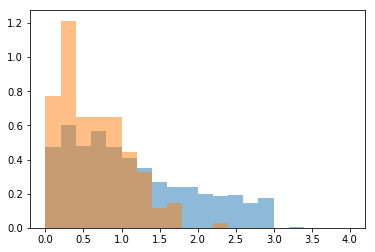

In [12]:
# Evaluate DNN on testing data
x = torch.tensor(X_test,dtype=torch.float)
y_pred = model(x).detach().numpy()[:,0]

# Find the threshold corresponding to 70% efficiency for true signal events
threshold = np.percentile(y_pred[y_test==1],70)

# select events that pass (ie lie above that threshold)
passed_selection = (y_pred > threshold)

# Plot the distribution of all events before and after the selection
_ = plt.hist(X_test[:,0],bins=20,density=True,range=(0,4),alpha=0.5)
_ = plt.hist(X_test[passed_selection,0],bins=20,density=True,range=(0,4),alpha=0.5)

# and calculate the jensen shannon divergence
calc_js(X_test[:,0],X_test[passed_selection,0])

# Homework 3 - Addition

The above result is not very good. Let's try to flatten signal and background separately

In [13]:
# Calculate weights

# build index arrays to select signal and background
is_signal = labels==1
is_bg    = labels==0

# Same as above
histogram_sig, edges_sig = np.histogram(data[is_signal,0],bins=10, range=(0,4))
histogram_bg, edges_bg = np.histogram(data[is_bg,0],bins=10, range=(0,4))

# remove lover/uppermost edge. We use same edges for signal and background
edges = edges_sig[1:]
edges = edges[:9]

# weights are 1/bin contents
weights_sig = 1./ histogram_sig
weights_bg  = 1./ histogram_bg

/Users/gregor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/Users/gregor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


In [16]:
# SOLUTION
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        # 5 Inputs - 20 Hidden Nodes - 1 Output
        self.fc1 = nn.Linear(5, 20)
        self.fc2 = nn.Linear(20, 1)
        
    def forward(self, x):
        
        x = F.relu(self.fc1.forward(x))
        x = self.fc2.forward(x)

        x = F.sigmoid(x)

        return x

    
# Which device to use for NN calculations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

# Create network object
model = NeuralNet().to(device)

# Adam optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# how many epochs to train for
n_epochs = 20 

# how many examples / batch
batch_size = 5

# Keep track of the accuracies
train_accs = []
test_accs = []

/Users/gregor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])) is deprecated. Please ensure they have the same size.


Epoch: 0 Train Accuracy: 0.48133333333333334 Test Accuracy: 0.4784
Epoch: 1 Train Accuracy: 0.502 Test Accuracy: 0.4976
Epoch: 2 Train Accuracy: 0.514 Test Accuracy: 0.5156
Epoch: 3 Train Accuracy: 0.5253333333333333 Test Accuracy: 0.5328
Epoch: 4 Train Accuracy: 0.5446666666666666 Test Accuracy: 0.55
Epoch: 5 Train Accuracy: 0.5613333333333334 Test Accuracy: 0.5672
Epoch: 6 Train Accuracy: 0.5753333333333334 Test Accuracy: 0.5864
Epoch: 7 Train Accuracy: 0.5913333333333334 Test Accuracy: 0.6044
Epoch: 8 Train Accuracy: 0.6146666666666667 Test Accuracy: 0.6232
Epoch: 9 Train Accuracy: 0.6373333333333333 Test Accuracy: 0.6448
Epoch: 10 Train Accuracy: 0.6633333333333333 Test Accuracy: 0.6632
Epoch: 11 Train Accuracy: 0.6873333333333334 Test Accuracy: 0.6848
Epoch: 12 Train Accuracy: 0.7066666666666667 Test Accuracy: 0.7008
Epoch: 13 Train Accuracy: 0.716 Test Accuracy: 0.7176
Epoch: 14 Train Accuracy: 0.732 Test Accuracy: 0.7304
Epoch: 15 Train Accuracy: 0.744 Test Accuracy: 0.7424
Epoc

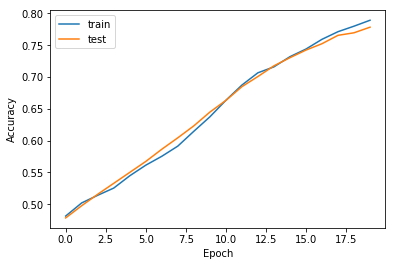

Best test accuracy: 0.7784


In [17]:
train_examples = X_train.shape[0]
n_batches = int(train_examples/batch_size)

# Loop over the epochs
for ep in range(n_epochs):

    # Calculate the weights
    # np.where allows us to pick from signal/background as needed    
    weights_train = np.where(y_train, weights_sig[np.digitize(X_train[:,0],edges)],
                                      weights_bg[np.digitize(X_train[:,0],edges)])

    weights_test = np.where(y_test, weights_sig[np.digitize(X_test[:,0],edges)],
                                      weights_bg[np.digitize(X_test[:,0],edges)])
    
    # Each epoch is a complete loop over the training data
    for i in range(n_batches):
        
        # Reset gradient
        optimizer.zero_grad()
        
        i_start = i*batch_size
        i_stop  = (i+1)*batch_size
        
        # Convert x and y to proper objects for PyTorch
        x = torch.tensor(X_train[i_start:i_stop],dtype=torch.float)
        y = torch.tensor(y_train[i_start:i_stop],dtype=torch.long)

        # select the right weights and convert to torch tensor
        w = torch.tensor(weights_train[i_start:i_stop],dtype=torch.float)
        
        
        # Apply the network 
        net_out = model(x)
        
        # train and apply weights
        loss = F.binary_cross_entropy(net_out,y.float(),weight=w)
            
        # Calculate the gradients
        loss.backward()

        # Update the weights
        optimizer.step()
        

    # end of loop over batches
        
   # Calculate predictions on training and testing data
    y_pred_train = model(torch.tensor(X_train,dtype=torch.float)).detach().numpy()[:,0]
    y_pred_test  = model(torch.tensor(X_test,dtype=torch.float)).detach().numpy()[:,0]
    
    # Calculate accuracy on training and testing data
    train_acc = sum(y_train.astype(bool) == (y_pred_train>0.5)) / y_train.shape[0]
    test_acc = sum(y_test.astype(bool) == (y_pred_test>0.5)) / y_test.shape[0]
        
    # print some information
    print("Epoch:",ep, "Train Accuracy:", train_acc,  "Test Accuracy:", test_acc)
    
    # and store the accuracy for later use
    train_accs.append(train_acc)
    test_accs.append(test_acc)
# end of loop over epochs
    
# Prepare and show accuracy over time
plt.axis('on')
plt.plot(train_accs,label="train")
plt.plot(test_accs,label="test")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

print("Best test accuracy:",max(test_accs))


0.07561562055150484

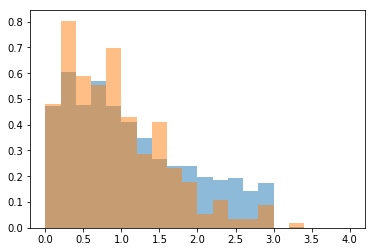

In [18]:
# Evaluate DNN on testing data
x = torch.tensor(X_test,dtype=torch.float)
y_pred = model(x).detach().numpy()[:,0]

# Find the threshold corresponding to 70% efficiency for true signal events
threshold = np.percentile(y_pred[y_test==1],70)

# select events that pass (ie lie above that threshold)
passed_selection = (y_pred > threshold)

# Plot the distribution of all events before and after the selection
_ = plt.hist(X_test[:,0],bins=20,density=True,range=(0,4),alpha=0.5)
_ = plt.hist(X_test[passed_selection,0],bins=20,density=True,range=(0,4),alpha=0.5)

# and calculate the jensen shannon divergence
calc_js(X_test[:,0],X_test[passed_selection,0])